In [ ]:
import warnings
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

warnings.filterwarnings("ignore")

#import sklearn
#sklearn.show_versions()
#sklearn.__version__
set_config(display='diagram')

| local auc | submitted auc | notes |
| ----- | ----- | ----- |
| 0.7909398964396033 | 0.81526 | lgbm, minmaxscaler |
| 0.7909827475776672 | 0.81549 | lgbm, robustscaler |
| 0.7909541319068296 | 0.81559 | lgbm, no scaler, **best** |
| 0.7908470220122795 | 0.81555 | lgbm, no scaler, count_na marked as categorical when fitting / slightly worse when submitted and locally |
| 0.7909180465160679 | 0.81554 | lgbm, no scaler, added high quality predictions and re-trained |
| 0.7909180465160679 | 0.81554 | as above but 800 estimators. exactly the same! weird! |


https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-environment

In [ ]:
data = pd.read_csv('data/train.csv', index_col=0)

In [4]:

from sklearn.preprocessing import MinMaxScaler, RobustScaler

def feature_generation(data):

    # add feature with number of na's per row + standard deviation
    features = [col for col in data.columns if 'f' in col] # if 'f' is in the name
    data['count_na'] = data[features].isna().sum(axis=1)

    features += ['count_na']

    # more important features: 'f40', 'f70', 'count_na', 'f47', 'f38'
    data['f40f70'] = data['f40'] * data['f70']
    data['f40f47'] = data['f40'] * data['f47']
    data['f40f38'] = data['f40'] * data['f38']
    data['f70f47'] = data['f70'] * data['f47']
    data['f70f38'] = data['f70'] * data['f38']
    data['f47f38'] = data['f47'] * data['f38']

    features += ['f40f70', 'f40f47', 'f40f38', 'f70f47', 'f70f38', 'f47f38']

    # now do imputation with mean
    # data[features] = data[features].fillna(data[features].mean())

    return data, features

#scaler = RobustScaler()
data, features = feature_generation(data)

#data[features] = scaler.fit_transform(data[features])


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
import lightgbm as lgb


# prepare the data
y = data.pop('claim')
X = data

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [6]:
print('Missing: ' , X.isna().sum().sum())

Missing:  2003224


In [7]:
from sklearn.impute import KNNImputer
from numpy import isnan

# print total missing
print('Missing: ' , X.isna().sum().sum())

imputer = KNNImputer() # by default n_neighbours =5, metric=nan_euclidean
imputer.fit(X)

X = imputer.transform(X)

# print total missing
print('Missing: ' , X.isna().sum().sum())

Missing:  2003224


In [ ]:
Xdf = pd.DataFrame(X, columns=features)
Xdf.to_csv('train_knn_imputed.csv')

In [69]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

params = {
    "colsample_bytree" : 0.738906888070166,
    "learning_rate" : 0.03489387357529748,
    "max_bin" : 64,
    "min_child_samples" : 112,
    "n_estimators" : 676,
    "num_leaves" : 19,
    "objective" : 'binary',
    "reg_alpha" : 0.0026503387318717064,
    "reg_lambda" : 0.31590573290271945,
    "subsample" : 0.9410633339183028,
    "metric" : 'auc',
    'boosting_type' : 'gbdt'
}

cat_cols_indices = [X.columns.get_loc(col) for col in ['count_na']]

classifier = LGBMClassifier(**params, random_state=42, n_jobs=-1) #, device_type = 'gpu'
classifier.fit(X, y) # categorical_feature=cat_cols_indices

LGBMClassifier(colsample_bytree=0.738906888070166,
               learning_rate=0.03489387357529748, max_bin=64, metric='auc',
               min_child_samples=112, n_estimators=676, num_leaves=19,
               objective='binary', random_state=42,
               reg_alpha=0.0026503387318717064, reg_lambda=0.31590573290271945,
               subsample=0.9410633339183028)

In [70]:
y_pred = classifier.predict(X)
roc_auc_score(y_pred, y)


0.7909541319068296

## Do scoring on testing, and retrain with the higher quality predictions

In [71]:
# predict on the holdout dataset
test_data = pd.read_csv('data/test.csv', index_col=0)
test_data, _ = feature_generation(test_data)
holdout_pred = classifier.predict_proba(test_data)
test_data['claim'] = holdout_pred[:,1]

# select predictions with 0.25 < prob < 0.75
high_confidence_predictions_df = test_data[(test_data['claim']>0.75) | (test_data['claim']<0.25)]
high_confidence_predictions_df[high_confidence_predictions_df['claim'] < 0.25] = 0
high_confidence_predictions_df[high_confidence_predictions_df['claim'] > 0.75] = 1


In [72]:
# split appart label
y_high_confidence_predictions_df = high_confidence_predictions_df.pop('claim')
X_high_confidence_predictions_df = high_confidence_predictions_df

# concatenate in a new dataframe
new_y = y.append(y_high_confidence_predictions_df)
new_X = X.append(X_high_confidence_predictions_df)


In [77]:
# train 
params2 = {
    "colsample_bytree" : 0.738906888070166,
    "learning_rate" : 0.03489387357529748,
    "max_bin" : 64,
    "min_child_samples" : 112,
    "n_estimators" : 800,
    "num_leaves" : 19,
    "objective" : 'binary',
    "reg_alpha" : 0.0026503387318717064,
    "reg_lambda" : 0.31590573290271945,
    "subsample" : 0.9410633339183028,
    "metric" : 'auc',
    'boosting_type' : 'gbdt'
}

classifier2 = LGBMClassifier(**params, random_state=42, n_jobs=-1) #device_type = 'gpu'
classifier2.fit(new_X, new_y)

y_pred = classifier2.predict(X)
print('auc = ', roc_auc_score(y_pred, y))

auc =  0.7909180465160679


In [80]:
test_data = pd.read_csv('data/test.csv', index_col=0)
test_data, _ = feature_generation(test_data)
#test_data = pd.DataFrame(scaler.transform(test_data), columns=features, index=test_data.index)

# holdout_pred = automl.predict(test_data)
holdout_pred = classifier2.predict_proba(test_data)

test_data['claim'] = holdout_pred[:,1]
submission = test_data['claim']
submission.to_csv('data/holdout_predictions.csv')
#data_to_save.reset_index()
#data_to_save.to_csv('data/holdout_predictions.csv', index=False)

In [81]:
print("done!")

done!


## Feature importances

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

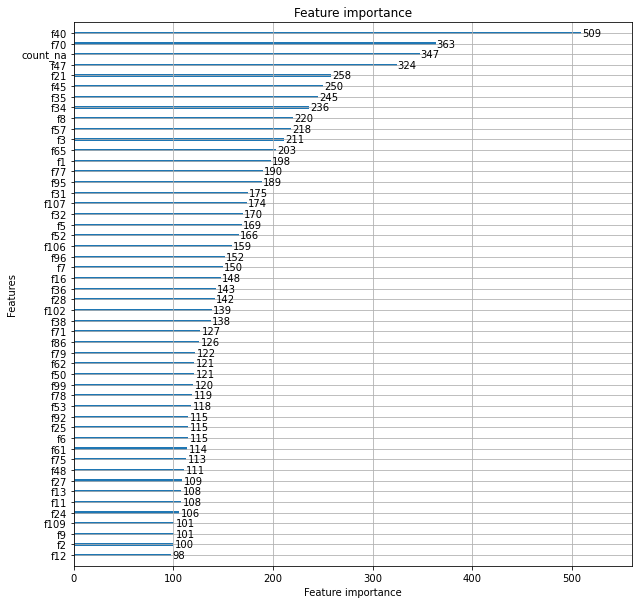

In [93]:
lgb.plot_importance(classifier, max_num_features=50, figsize=(10,10))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

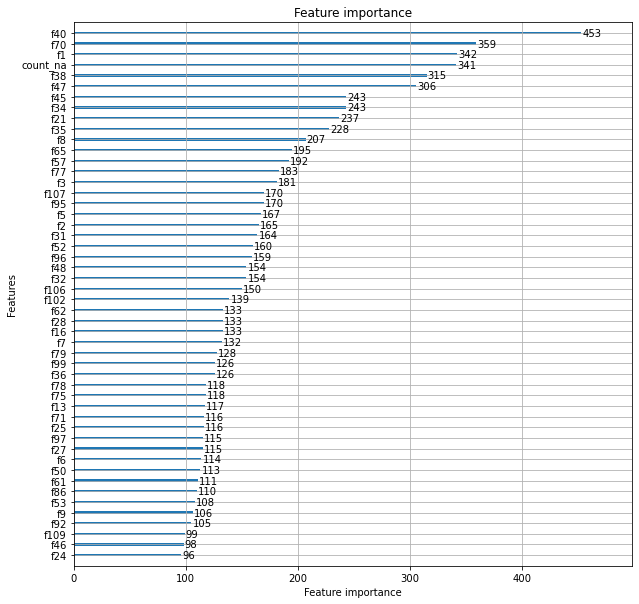

In [92]:
lgb.plot_importance(classifier2, max_num_features=50, figsize=(10,10))